In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['font.size'] = 18

In [3]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):
        real = inputs * tf.cos(0.0)
        imag = inputs * tf.sin(0.0)
        return tf.stack([real, imag], axis=1)

In [4]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    # input[0,:,:] = real
    # input[1,:,:] = image
    def build(self, input_dim):
        self.phi = self.add_variable("phi",
                                     shape=[int(input_dim[-2]),
                                            int(input_dim[-1])])

        super(CxMO, self).build(input_dim)

    def call(self, x):
        x_real = Lambda(lambda x: x[: ,0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[: ,1, :, :], output_shape=self.output_dim)(x)  # imag
        mo_real = tf.cos(self.phi)
        mo_imag = tf.sin(self.phi)

        real = x_real * mo_real - x_imag * mo_imag
        imag = x_real * mo_imag + x_imag * mo_real
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx

In [5]:
class FreeSpacePropagation(tf.keras.layers.Layer):
    def __init__(self, output_dim, k, z, input_pitch=1e-6, output_pitch=1e-6):
        super(FreeSpacePropagation, self).__init__()
        self.output_dim = output_dim
        self.input_pitch = input_pitch
        self.output_pitch = output_pitch
        self.z = z
        self.k = k

    def build(self, input_shape):

        x1 = np.arange(0, input_shape[-1], 1)
        y1 = np.arange(0, input_shape[-2], 1)
        xx1, yy1 = np.meshgrid(x1, y1)
        xx1 = xx1.reshape(-1, 1) - input_shape[-1]/2
        yy1 = yy1.reshape(-1, 1) - input_shape[-2]/2

        x2 = np.arange(0, self.output_dim[1], 1)
        y2 = np.arange(0, self.output_dim[0], 1)
        xx2, yy2 = np.meshgrid(x2, y2)
        xx2 = xx2.reshape(1, -1) - self.output_dim[1]/2
        yy2 = yy2.reshape(1, -1) - self.output_dim[0]/2

        dx = (self.output_pitch * xx2 - self.input_pitch * xx1)
        dy = (self.output_pitch * yy2 - self.input_pitch * yy1)
        r = np.sqrt(dx**2 + dy**2 + self.z**2)
        w = 1/(2*np.pi) * self.z / r * (1/r - 1j*self.k) * np.exp(1j * self.k * r)

        self.w_real = tf.Variable(initial_value=w.real.astype('float32'),
                                              trainable=False)
        self.w_imag = tf.Variable(initial_value=w.imag.astype('float32'),
                                              trainable=False)

        super(FreeSpacePropagation, self).build(input_shape)

    def call(self, x, **kwargs):
        x_real = Lambda(lambda x: x[:,0, :, :], output_shape=(self.output_dim,))(x)  # real
        x_imag = Lambda(lambda x: x[:,1, :, :], output_shape=(self.output_dim,))(x)  # imag
        x_real = tf.reshape(x_real, (-1, x.shape[-1]*x.shape[-2]))
        x_imag = tf.reshape(x_imag, (-1, x.shape[-1]*x.shape[-2]))
        real = tf.matmul(x_real, self.w_real) - tf.matmul(x_imag, self.w_imag)
        imag = tf.matmul(x_imag, self.w_real) + tf.matmul(x_real, self.w_imag)
        real = tf.reshape(real, (-1, self.output_dim[0], self.output_dim[1]))
        imag = tf.reshape(imag, (-1, self.output_dim[0], self.output_dim[1]))
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx


In [6]:
class CxD2NNMNISTDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(CxD2NNMNISTDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape
        self.width = int(tf.floor(self.input_dim[2]/4.0))
        self.height = int(tf.floor(self.input_dim[1]/3.0))
        super(CxD2NNMNISTDetector, self).build(input_shape)

    def plot_area(self, input_shape):
        width = int(tf.floor(input_shape[1]/4.0))
        height = int(tf.floor(input_shape[0]/3.0))
        x = np.zeros(input_shape)
        x[0:height-1, 0:width-1] = 1
        x[0:height-1, width:width*2-1] = 2
        x[0:height-1, width*2:width*3-1] = 3
        x[height:height*2-1, 0:width-1] = 4
        x[height:height*2-1, width:width*2-1] = 5
        x[height:height*2-1, width*2:width*3-1] = 6
        x[height:height*2-1, width*3:width*4-1] = 7
        x[height*2:height*3-1, 0:width-1] = 8
        x[height*2:height*3-1, width:width*2-1] = 9
        x[height*2:height*3-1, width*2:width*3-1] = 10
        plt.imshow(x)

    def call(self, x, **kwargs):
        y0 = x[:, 0:self.height-1, 0:self.width-1]
        y1 = x[:, 0:self.height-1, self.width:self.width*2-1]
        y2 = x[:, 0:self.height-1, self.width*2:self.width*3-1]
        y3 = x[:, self.height:self.height*2-1, 0:self.width-1]
        y4 = x[:, self.height:self.height*2-1, self.width:self.width*2-1]
        y5 = x[:, self.height:self.height*2-1, self.width*2:self.width*3-1]
        y6 = x[:, self.height:self.height*2-1, self.width*3:self.width*4-1]
        y7 = x[:, self.height*2:self.height*3-1, 0:self.width-1]
        y8 = x[:, self.height*2:self.height*3-1, self.width:self.width*2-1]
        y9 = x[:, self.height*2:self.height*3-1, self.width*2:self.width*3-1]
        y0 = tf.reduce_sum(y0, axis=[1])
        y0 = tf.reduce_sum(y0, axis=[1], keepdims=True)
        y1 = tf.reduce_sum(y1, axis=[1])
        y1 = tf.reduce_sum(y1, axis=[1], keepdims=True)
        y2 = tf.reduce_sum(y2, axis=[1])
        y2 = tf.reduce_sum(y2, axis=[1], keepdims=True)
        y3 = tf.reduce_sum(y3, axis=[1])
        y3 = tf.reduce_sum(y3, axis=[1], keepdims=True)
        y4 = tf.reduce_sum(y4, axis=[1])
        y4 = tf.reduce_sum(y4, axis=[1], keepdims=True)
        y5 = tf.reduce_sum(y5, axis=[1])
        y5 = tf.reduce_sum(y5, axis=[1], keepdims=True)
        y6 = tf.reduce_sum(y6, axis=[1])
        y6 = tf.reduce_sum(y6, axis=[1], keepdims=True)
        y7 = tf.reduce_sum(y7, axis=[1])
        y7 = tf.reduce_sum(y7, axis=[1], keepdims=True)
        y8 = tf.reduce_sum(y8, axis=[1])
        y8 = tf.reduce_sum(y8, axis=[1], keepdims=True)
        y9 = tf.reduce_sum(y9, axis=[1])
        y9 = tf.reduce_sum(y9, axis=[1], keepdims=True)
        y = tf.keras.layers.concatenate([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9])

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)
        return y

In [7]:
class CxD2NNIntensity(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization='min_max', **kwargs):
        super(CxD2NNIntensity, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.normalization = normalization

    def call(self, x, **kwargs):
        real = Lambda(lambda x: x[:, 0, :, :])(x)
        image = Lambda(lambda x: x[:, 1, :, :])(x)
        intensity = tf.sqrt(real ** 2 + image ** 2)
        if self.normalization == 'min_max':
            max = tf.reduce_max(intensity)
            min = tf.reduce_min(intensity)
            intensity = (intensity - min)/(max - min)
        return intensity

In [8]:
class MOD2NN(tf.keras.Model):
    def __init__(self):
        super(MOD2NN, self).__init__()
        self.l = 633e-9
        self.k = 2 * np.pi / self.l
        self.d = 1e-6
        self.mo1 = CxMO((28, 28))
        self.propag1 = FreeSpacePropagation((28, 28), self.d, 2e-3, self.k)
        self.mo2 = CxMO((28, 28))
        self.prooag2 = FreeSpacePropagation((1, 10), self.d*2, 1e-9, self.k)

    def call(self, x):
        x = self.mo1(inputs)
        x = self.propag1(x)
        x = self.mo2(x)
        x = self.prooag2(x)
        x = tf.nn.softmax(x[0,:,:])

        return x

In [9]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)

In [10]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [11]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6


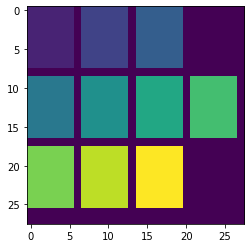

In [12]:

detector = CxD2NNMNISTDetector(10)
detector.plot_area((28, 28))

In [93]:
inputs = keras.Input((28,28))
x = InputToCx((28, 28))(inputs)
x = CxMO((28, 28))(x)
x = FreeSpacePropagation((28, 28), k, 1e-4, output_pitch=1e-6)(x)
x = CxD2NNIntensity((28, 28), normalization='min_max')(x)
x = CxD2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#result = model.fit(x_train, y_train, batch_size=64, epochs=10)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 input_to_cx_13 (InputToCx)  (None, 2, 28, 28)         0         
                                                                 
 cx_mo_13 (CxMO)             (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_11 (  (None, 2, 28, 28)        1229312   
 FreeSpacePropagation)                                           
                                                                 
 cx_d2nn_intensity_10 (CxD2N  (None, 28, 28)           0         
 NIntensity)                                                     
                                                                 
 cx_d2nnmnist_detector_10 (C  (None, 10)               0  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  # This is added back by InteractiveShellApp.init_path()


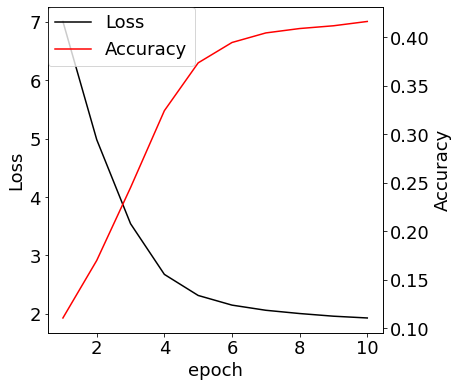

In [59]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, 11), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, 11), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

array([[0.04593584, 0.01391635, 0.01915953, 0.03928459, 0.10830791,
        0.3538724 , 0.00767871, 0.07761943, 0.06080932, 0.27341592]],
      dtype=float32)

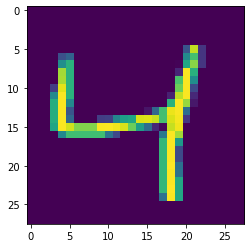

In [ ]:
plt.imshow(x_train[2,:,:])
out = model.predict(np.array([x_train[2,:,:]]))
out

In [94]:
layer_name = 'cx_d2nn_intensity_10'
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

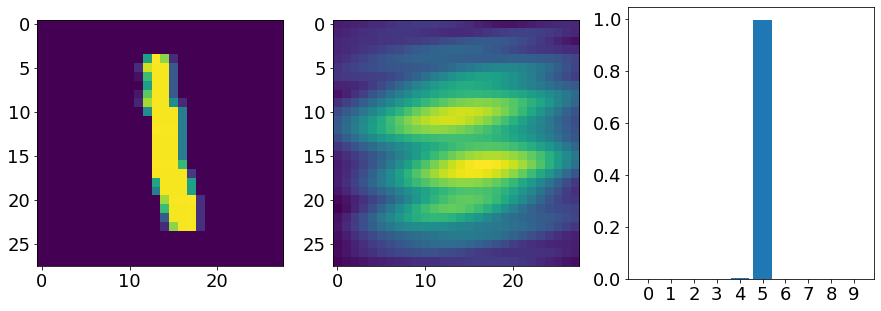

In [96]:
image = x_train[6,:,:]
hidden_out = hidden_layer_model.predict(np.array([image]))
pred = model.predict(np.array([image]))

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(image)
axes[1].imshow(hidden_out[0, :, :])
axes[2].bar(np.arange(0, 10, 1), pred[0,:], align='center')
axes[2].set_xticks(np.arange(0, 10, 1))

In [67]:
inputs = tf.keras.Input((28, 28))
x = InputToCx((28, 28))(inputs)
x = CxMO((28, 28))(x)
x = FreeSpacePropagation((28, 28), k, 1e-4)(x)
x = CxD2NNIntensity((28, 28))(x)
model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 input_to_cx_7 (InputToCx)   (None, 2, 28, 28)         0         
                                                                 
 cx_mo_7 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_5 (F  (None, 2, 28, 28)        1229312   
 reeSpacePropagation)                                            
                                                                 
 cx_d2nn_intensity_4 (CxD2NN  (None, 28, 28)           0         
 Intensity)                                                      
                                                                 
Total params: 1,230,096
Trainable params: 784
Non-trainabl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  # This is added back by InteractiveShellApp.init_path()


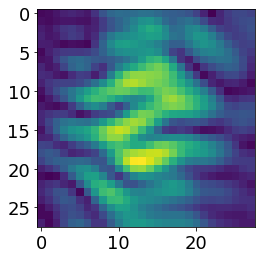

In [68]:
out = model.predict(np.array([x_train[0, :, :]]))
plt.imshow(out[0,:,:])

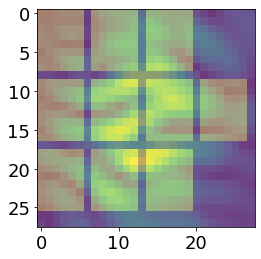

In [80]:
width = int(tf.floor(28/4.0))
height = int(tf.floor(28/3.0))
x = np.zeros((28, 28))
x[0:height-1, 0:width-1] = 10
x[0:height-1, width:width*2-1] = 10
x[0:height-1, width*2:width*3-1] = 10
x[height:height*2-1, 0:width-1] = 10
x[height:height*2-1, width:width*2-1] = 10
x[height:height*2-1, width*2:width*3-1] = 10
x[height:height*2-1, width*3:width*4-1] = 10
x[height*2:height*3-1, 0:width-1] = 10
x[height*2:height*3-1, width:width*2-1] = 10
x[height*2:height*3-1, width*2:width*3-1] = 10
alpha = 0.7
plt.imshow(out[0,:,:], alpha=alpha)
plt.imshow(x, alpha=1-alpha)